In [1]:
import pandas as pd
import regex as re
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [2]:
path_raw = '/home/matteo@COPPET/Documents/data_science/projects/housing_prices_firenze/data/raw/'

In [3]:
caratteristiche = pd.read_excel(path_raw+'caratteristiche.xlsx')
costi = pd.read_excel(path_raw+'costi.xlsx')
efficienza_energetica = pd.read_excel(path_raw+'efficienza_energetica.xlsx')

In [532]:
caratteristiche.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9065 entries, 0 to 9064
Data columns (total 17 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   immobile garantito                            3821 non-null   object 
 1   riferimento e Data annuncio                   9065 non-null   object 
 2   contratto                                     9065 non-null   object 
 3   tipologia                                     9065 non-null   object 
 4   superficie                                    9057 non-null   object 
 5   locali                                        9049 non-null   object 
 6   piano                                         8862 non-null   object 
 7   totale piani edificio                         8359 non-null   object 
 8   disponibilità                                 8081 non-null   object 
 9   Tipo proprietà                                8583 non-null   o

In [533]:
costi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9065 entries, 0 to 9064
Data columns (total 13 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   prezzo                                 9065 non-null   object 
 1   informazioni catastali                 5805 non-null   object 
 2   spese condominio                       5248 non-null   object 
 3   stato                                  0 non-null      float64
 4   certificazione energetica              0 non-null      float64
 5   Efficienza energetica                  0 non-null      float64
 6   Tipo vendita                           0 non-null      float64
 7   data vendita                           0 non-null      float64
 8   riscaldamento                          0 non-null      float64
 9   anno di costruzione                    0 non-null      float64
 10  Prestazione energetica del fabbricato  0 non-null      float64
 11  Clim

In [534]:
efficienza_energetica.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9065 entries, 0 to 9064
Data columns (total 15 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   anno di costruzione                    6557 non-null   float64
 1   stato                                  8803 non-null   object 
 2   riscaldamento                          8645 non-null   object 
 3   Climatizzazione                        4950 non-null   object 
 4   Indice prest. energetica rinnovabile   287 non-null    object 
 5   Prestazione energetica del fabbricato  594 non-null    object 
 6   Efficienza energetica                  7809 non-null   object 
 7   certificazione energetica              1370 non-null   object 
 8   numero immobili                        0 non-null      float64
 9   offerta minima                         0 non-null      float64
 10  rialzo minimo                          0 non-null      float64
 11  Spes

In [4]:
# Drop NaN columns (based on info above, possible error in scraping)
caratteristiche = caratteristiche.drop(columns=['unità', 'Data di inizio lavori e di consegna prevista', 'Dati catastali'])
costi = costi.iloc[:, :3]
efficienza_energetica = efficienza_energetica.iloc[:, :8]

In [140]:
efficienza_energetica.head()

,anno di costruzione,stato,riscaldamento,Climatizzazione,Indice prest. energetica rinnovabile,Prestazione energetica del fabbricato,Efficienza energetica,certificazione energetica
0,1960.0,Ottimo / Ristrutturato,"Autonomo, a radiatori, alimentato a metano","Autonomo, freddo/caldo",NaN,NaN,"E 175,00 kWh/m² anno",NaN
1,1500.0,Buono / Abitabile,"Autonomo, a radiatori, alimentazione elettrica",NaN,NaN,NaN,NaN,Esente
2,1902.0,NaN,"Autonomo, a radiatori, alimentato a metano",NaN,NaN,NaN,In attesa di certificazione,"G 342,60 kWh/m² anno"
3,1500.0,Buono / Abitabile,"Autonomo, a radiatori, alimentato a metano",NaN,NaN,NaN,NaN,Non classificabile
4,1980.0,Buono / Abitabile,"Centralizzato, a radiatori",NaN,NaN,invernale estivo,G,NaN


### Join all three tables and start looking into the data

In [5]:
# Join tables
df = caratteristiche.join(costi).join(efficienza_energetica)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9065 entries, 0 to 9064
Data columns (total 25 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   immobile garantito                     3821 non-null   object 
 1   riferimento e Data annuncio            9065 non-null   object 
 2   contratto                              9065 non-null   object 
 3   tipologia                              9065 non-null   object 
 4   superficie                             9057 non-null   object 
 5   locali                                 9049 non-null   object 
 6   piano                                  8862 non-null   object 
 7   totale piani edificio                  8359 non-null   object 
 8   disponibilità                          8081 non-null   object 
 9   Tipo proprietà                         8583 non-null   object 
 10  altre caratteristiche                  8488 non-null   object 
 11  Post

In [7]:
# Rename columns
df.columns = map(str.capitalize, df.columns)
df = df.rename(columns={'Superficie': 'Superficie [m2]', 'Prezzo': 'Prezzo [EUR]'})

In [8]:
# Remove rentals
df = df.loc[df['Contratto'] != 'Affitto', :]

# Checking for and removing duplicates
df.duplicated().sum()
df = df.drop_duplicates()

In [ ]:
df.loc[df['Zona'].isna(), :]

In [9]:
# Clean up data types
df['Superficie [m2]'] = (df['Superficie [m2]']
                         .str.split('m²')
                         .str[0]
                         .astype('float'))

df['Totale piani edificio'] = (df['Totale piani edificio']
                               .str.split(' ')
                               .str[0])

df['Zona'] = (df['Zona']
              .str.replace('-', ' ')
              .str.replace('/', '')
              .str.title())

df['Prezzo [EUR]'] = (df['Prezzo [EUR]']
                      .str.split('€')
                      .str[1]
                      .str.replace('.', '')
                      .astype('float'))

In [10]:
df['Prezzo [EUR]'].mean()

488736.5661714286

In [94]:
df['Tipologia'].unique()

array(['Appartamento', 'Terratetto unifamiliare', 'Villa unifamiliare',
       'Terratetto plurifamiliare', 'Rustico', 'Villa a schiera', 'Loft',
       'Attico', 'Open space', 'Villa bifamiliare',
       'Appartamento in villa', 'Casa colonica', 'Casale', 'Mansarda',
       'Villa plurifamiliare', 'Bed & Breakfast', 'Ufficio', 'Cascina'],
      dtype=object)

In [ ]:
# Drop columns that have almost no entries
df = df.drop(columns=['Immobile garantito', 'Indice prest. energetica rinnovabile',
                      'Prestazione energetica del fabbricato', 'Certificazione energetica'])


7671

### Feature engineering

#### Heating

In [395]:
df['Riscaldamento'].unique()

array(['Autonomo, a radiatori, alimentato a metano',
       'Autonomo, a radiatori, alimentazione elettrica',
       'Centralizzato, a radiatori', 'Autonomo, a radiatori', 'Autonomo',
       'Centralizzato, a radiatori, alimentato a metano', nan,
       'Autonomo, alimentato a gas',
       'Centralizzato, a radiatori, alimentato a gas',
       'Centralizzato, a pavimento, alimentato a fotovoltaico',
       'Centralizzato, a pavimento, alimentato a gas',
       'Autonomo, a radiatori, alimentato a gas',
       'Centralizzato, alimentato a metano', 'Autonomo, ad aria',
       'Autonomo, a stufa', 'Centralizzato, a pavimento', 'Centralizzato',
       'Autonomo, a pavimento, alimentato a metano',
       'Centralizzato, a pavimento, alimentato a metano',
       'Autonomo, ad aria, alimentato a pompa di calore',
       'Autonomo, a pavimento, alimentato a gas',
       'Autonomo, ad aria, alimentato a gas',
       'Autonomo, a pavimento, alimentazione elettrica',
       'Autonomo, a radiatori

In [11]:
# Create type of heating feature
df['Tipologia di riscaldamento'] = df['Riscaldamento'].str.split(',').str[0]

#### Listing date

In [65]:
df['Riferimento e data annuncio'].head(100)

0                             A0049 - 05/10/2020
1                            alv275 - 05/10/2020
2                          Novoli B - 05/10/2020
3                          Novoli A - 05/10/2020
4                           MAZZ328 - 05/10/2020
                         ...                    
95                      37551014-27 - 04/10/2020
96                      EK-83077277 - 03/10/2020
97                       33201042-1 - 04/10/2020
98    923287/1151/ARTISTI A) 205000 - 05/10/2020
99                         40365013 - 03/10/2020
Name: Riferimento e data annuncio, Length: 100, dtype: object

In [87]:
df['Data annuncio'] = (df['Riferimento e data annuncio']
                       .str.split('-')
                       .str[-1]
                       .str.strip()
                       .astype('datetime64[D]'))

#### Number of rooms and toilets

In [12]:
# Create number of rooms feature
pat = r'\(.*\)'
repl = lambda m: m.group(0).replace(',', ';')

df['Locali'] = df['Locali'].str.replace(pat, repl)

In [13]:
# TO FLOAT? 3+
df['Numero di bagni'] = (df['Locali']
                         .str.findall(r'(\d\+? bagn\w)')
                         .str[0]
                         .str.split(' ')
                         .str[0]
                        )
df.loc[df['Numero di bagni'].isna(), 'Numero di bagni'] = 0
df.loc[df['Numero di bagni'] == '3+', 'Numero di bagni'] = 4
df['Numero di bagni'] = df['Numero di bagni'].astype('float')

In [14]:
df['Numero di bagni'].value_counts()

1.0    4450
2.0    3055
3.0     842
4.0     570
0.0     122
Name: Numero di bagni, dtype: int64

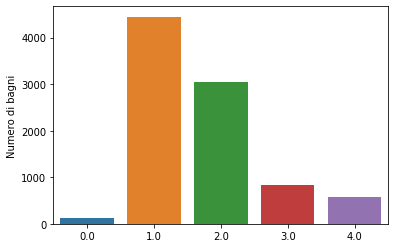

In [15]:
sns.barplot(x=df['Numero di bagni'].value_counts().index, y=df['Numero di bagni'].value_counts())

In [16]:
df.loc[df['Numero di bagni'] == 0, :]

,Immobile garantito,Riferimento e data annuncio,Contratto,Tipologia,Superficie [m2],Locali,Piano,Totale piani edificio,Disponibilità,Tipo proprietà,Altre caratteristiche,Posti auto,Indirizzo,Zona,Prezzo [EUR],Informazioni catastali,Spese condominio,Anno di costruzione,Stato,Riscaldamento,Climatizzazione,Indice prest. energetica rinnovabile,Prestazione energetica del fabbricato,Efficienza energetica,Certificazione energetica,Tipologia di riscaldamento,Numero di bagni
99,"Dati certificabili, documentazione completa ...",40365013 - 03/10/2020,Vendita,Appartamento,120.0,"5 locali, cucina abitabile","Piano rialzato, con ascensore",NaN,NaN,Classe immobile media,Cantina,NaN,"['Firenze', 'Campo di Marte', 'Via Cento Stell...",Campo Di Marte Liberta,248000.0,NaN,NaN,1960.0,Buono / Abitabile,"Centralizzato, a radiatori, alimentato a metano",NaN,NaN,NaN,"G 238,75 kWh/m² anno",NaN,Centralizzato,0.0
119,NaN,5599 - 02/10/2020,Vendita,Appartamento,500.0,5 locali,2° piano,3,Libero,"Intera proprietà, classe immobile signorile",Esposizione esterna,NaN,"['Firenze', 'Duomo']",Centro,5000.0,NaN,NaN,NaN,Buono / Abitabile,NaN,NaN,NaN,NaN,"G 175,00 kWh/m² anno",NaN,NaN,0.0
329,NaN,RAchiantigiana - 02/10/2020,Vendita,Rustico,250.0,5 locali,NaN,NaN,Libero,NaN,NaN,NaN,"['Firenze', 'Chiantigiana - Ponte a Ema']",Zona Firenze Sud,950000.0,NaN,NaN,NaN,Buono / Abitabile,NaN,NaN,NaN,NaN,G,NaN,NaN,0.0
409,NaN,40363014 - 30/09/2020,Vendita,Appartamento,95.0,5 locali,"Piano terra, con ascensore",NaN,Libero,Classe immobile economica,Giardino privato,NaN,"['Firenze', 'Campo di Marte', 'Via Cairoli', '...",Campo Di Marte Liberta,310000.0,NaN,€ 90/mese,1950.0,Ottimo / Ristrutturato,"Centralizzato, a radiatori, alimentato a metano",NaN,NaN,NaN,"G 175,00 kWh/m² anno",NaN,Centralizzato,0.0
441,NaN,EK-82996995 - 30/09/2020,Vendita,Appartamento,200.0,2 (1 camera da letto; 1 altro),"1° piano, con ascensore",NaN,Libero,Intera proprietà,Cantina,1 in garage/box,"['Firenze', ""D'Azeglio"", ""Piazza Massimo d'Aze...",Centro,1800000.0,NaN,€ 10.000/mese,NaN,Buono / Abitabile,Centralizzato,NaN,NaN,NaN,NaN,NaN,Centralizzato,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8773,NaN,40001715 - 26/09/2020,Vendita,Appartamento,21.0,1 locale,Seminterrato,4,Libero,Intera proprietà,Cantina,NaN,"['Firenze', 'Campo di Marte', 'Viale Terenzio ...",Campo Di Marte Liberta,21000.0,Rendita € 109,NaN,1940.0,Da ristrutturare,NaN,NaN,NaN,NaN,NaN,Esente,NaN,0.0
8960,NaN,IT000000000000 - 26/06/2020,Vendita,Appartamento,172.0,NaN,Piano terra,NaN,NaN,NaN,NaN,NaN,"['Firenze', 'Libertà - Savonarola', 'via Barto...",Campo Di Marte Liberta,420000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"G 175,00 kWh/m² anno",NaN,NaN,0.0
8987,NaN,A2476 - 10/07/2017,Vendita,Appartamento,380.0,5 locali,Piano terra,3,NaN,NaN,Giardino comune,NaN,"['Firenze', 'Via del Pian dei Giullari', 'Cinq...",Zona Firenze Sud,NaN,NaN,NaN,NaN,NaN,Autonomo,NaN,NaN,NaN,G ≥ 175 kWh/m² anno,NaN,Autonomo,0.0
9031,NaN,2196 - 10/02/2016,Vendita,Villa unifamiliare,1.4,"5 locali, cucina abitabile",Su più livelli,3,Libero,Immobile di lusso,Cancello elettrico\n \n\n ...,2 in garage/box,"['Firenze', 'Cinque Vie']",Zona Firenze Sud,NaN,NaN,NaN,1400.0,Buono / Abitabile,Autonomo,NaN,NaN,NaN,"G 250,00 kWh/m² anno",NaN,Autonomo,0.0


In [17]:
df['Numero di altri'] = (df['Locali']
                         .str.findall(r'(\d?\d\+? altr\w)')
                         .str[0]
                         .str.split(' ')
                         .str[0]
                         .astype('float'))
df.loc[df['Numero di altri'].isna(), 'Numero di altri'] = 0

In [18]:
df['Numero di camere da letto'] = (df['Locali']
                                   .str.findall(r'(\d?\d\+? camer\w da letto)')
                                   .str[0]
                                   .str.split(' ')
                                   .str[0]
                                   .astype('float'))
df.loc[df['Numero di camere da letto'].isna(), 'Numero di camere da letto'] = 0

In [19]:
df['Numero di locali'] = (df['Locali']
                          .str.findall(r'(\d?\d\+? local\w)')
                          .str[0]
                          .str.split(' ')
                          .str[0]
                          .astype('float'))
df.loc[df['Numero di locali'].isna(), 'Numero di locali'] = 0

In [20]:
df['Numero totale di locali'] = df['Numero di locali'] + df['Numero di camere da letto'] + df['Numero di altri']

In [28]:
df.loc[df['Locali'].isna(), :]

,Immobile garantito,Riferimento e data annuncio,Contratto,Tipologia,Superficie [m2],Locali,Piano,Totale piani edificio,Disponibilità,Tipo proprietà,Altre caratteristiche,Posti auto,Indirizzo,Zona,Prezzo [EUR],Informazioni catastali,Spese condominio,Anno di costruzione,Stato,Riscaldamento,Climatizzazione,Indice prest. energetica rinnovabile,Prestazione energetica del fabbricato,Efficienza energetica,Certificazione energetica,Tipologia di riscaldamento,Numero di bagni,Numero di altri,Numero di camere da letto,Numero di locali,Numero totale di locali
1279,NaN,AC023 - 18/09/2020,Vendita,Appartamento,NaN,NaN,NaN,NaN,NaN,Intera proprietà,NaN,NaN,"['Firenze', 'Peretola']",Firenze Nord,240000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G,NaN,NaN,0.0,0.0,0.0,0.0,0.0
2215,NaN,EK-82434812 - 07/09/2020,Vendita,Appartamento,30.0,NaN,4° piano,4,NaN,Intera proprietà,NaN,NaN,"['Firenze', 'Via Aretina', 'Alberti - Bellariv...",Coverciano Bellariva,120000.0,NaN,NaN,NaN,Ottimo / Ristrutturato,Autonomo,NaN,NaN,NaN,NaN,Non classificabile,Autonomo,0.0,0.0,0.0,0.0,0.0
2528,NaN,EK-82305466 - 17/09/2020,Vendita,Appartamento,110.0,NaN,5° piano,NaN,NaN,NaN,NaN,NaN,"['Firenze', 'Bolognese', 'Via Federigo Stibber...",Zona Bolognese Le Cure,330000.0,NaN,€ 130/mese,NaN,NaN,Centralizzato,NaN,NaN,NaN,NaN,NaN,Centralizzato,0.0,0.0,0.0,0.0,0.0
2761,NaN,EK-82121414 - 16/08/2020,Vendita,Terratetto plurifamiliare,220.0,NaN,NaN,NaN,Libero,Intera proprietà,Giardino privato,NaN,"['Firenze', 'Via Chiantigiana', 'San Marcellin...",Zona Firenze Sud,1190000.0,NaN,NaN,NaN,Ottimo / Ristrutturato,Autonomo,NaN,NaN,NaN,A3,NaN,Autonomo,0.0,0.0,0.0,0.0,0.0
4819,NaN,EK-80826163 - 08/09/2020,Vendita,Appartamento,75.0,NaN,Piano terra,NaN,Libero,Intera proprietà,Giardino privato,NaN,"['Firenze', 'Brozzi', 'Via della Saggina, 23/1...",Firenze Nord,230000.0,NaN,NaN,NaN,Buono / Abitabile,Autonomo,NaN,NaN,NaN,G,NaN,Autonomo,0.0,0.0,0.0,0.0,0.0
5504,NaN,Hemera_DRM_Hemera_38_001 - 29/09/2020,Vendita,Appartamento,120.0,NaN,Piano terra,NaN,Libero,"Intera proprietà, classe immobile media",NaN,NaN,"['Firenze', 'via FRANCESCO BARACCA, 149', 'Nov...",Firenze Nord,363000.0,NaN,NaN,NaN,Buono / Abitabile,"Centralizzato, a radiatori","Autonomo, freddo",NaN,NaN,"G 175,00 kWh/m² anno",NaN,Centralizzato,0.0,0.0,0.0,0.0,0.0
6273,NaN,V 770 - 25/02/2020,Vendita,Villa unifamiliare,240.0,NaN,1° piano,2,Libero,"Intera proprietà, immobile di lusso",NaN,NaN,"['Firenze', 'Settignano', 'Via della Capponcina']",Settignano Rovezzano,1500000.0,NaN,NaN,1900.0,Ottimo / Ristrutturato,NaN,NaN,NaN,NaN,NaN,In attesa di certificazione,NaN,0.0,0.0,0.0,0.0,0.0
7073,NaN,EK-77934526 - 06/09/2020,Vendita,Villa unifamiliare,320.0,NaN,da seminterrato a 1°,2,Libero,"Intera proprietà, classe immobile signorile",NaN,NaN,"['Firenze', 'Via Coppo di Marcovaldo', 'Soffia...",Legnaia Soffiano,890000.0,NaN,NaN,NaN,Buono / Abitabile,NaN,NaN,NaN,NaN,G ≥ 175 kWh/m² anno,NaN,NaN,0.0,0.0,0.0,0.0,0.0
7285,NaN,VLLPAN26 (2610274) - 11/06/2020,Vendita,Villa unifamiliare,300.0,NaN,Su più livelli,NaN,Libero,Classe immobile signorile,Cancello elettrico\n \n\n ...,NaN,"['Firenze', 'Piazzale Michelangelo']",NaN,2300000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"G 175,00 kWh/m² anno",In attesa di certificazione,NaN,0.0,0.0,0.0,0.0,0.0
7395,NaN,EK-76941862 - 03/08/2020,Vendita,Appartamento,55.0,NaN,"4° piano, con ascensore",NaN,Libero,Intera proprietà,Cantina,NaN,"['Firenze', 'Alberti - Bellariva', 'Via France...",Coverciano Bellariva,235000.0,NaN,NaN,NaN,Buono / Abitabile,Autonomo,NaN,NaN,NaN,NaN,Non classificabile,Autonomo,0.0,0.0,0.0,0.0,0.0


In [ ]:
# How to deal with NaN locali? Impute according to m2 area




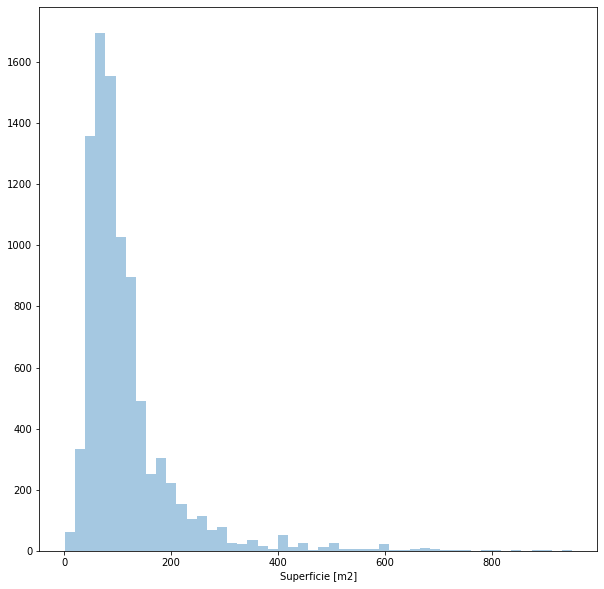

In [21]:
# Area [m2] distribution
fig = plt.figure(figsize=(10, 10))
sns.distplot(df['Superficie [m2]'], kde=False)

In [461]:
df['Superficie_Bins'] = pd.cut(df['Superficie [m2]'], bins=[0, 60, 80, 100, 120, 160, 200, 10000])

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

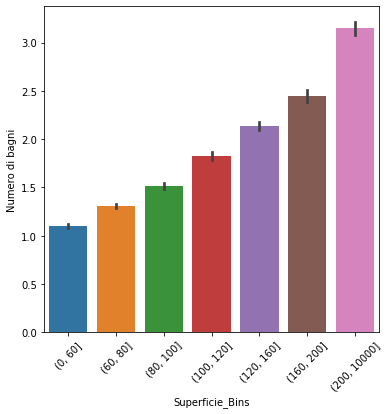

In [498]:
fig = plt.figure(figsize=(6, 6))
sns.barplot(x=df['Superficie_Bins'], y=df['Numero di bagni'])
plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

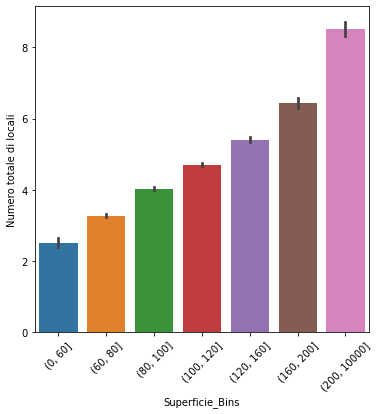

In [511]:
fig = plt.figure(figsize=(6, 6))
sns.barplot(x=df['Superficie_Bins'], y=df['Numero totale di locali'])
plt.xticks(rotation=45)

In [463]:
df.loc[df['Locali'].isna(), :]

,Immobile garantito,Riferimento e data annuncio,Contratto,Tipologia,Superficie [m2],Locali,Piano,Totale piani edificio,Disponibilità,Tipo proprietà,Altre caratteristiche,Posti auto,Indirizzo,Zona,Prezzo [EUR],Informazioni catastali,Spese condominio,Anno di costruzione,Stato,Riscaldamento,Climatizzazione,Indice prest. energetica rinnovabile,Prestazione energetica del fabbricato,Efficienza energetica,Certificazione energetica,Tipologia di riscaldamento,Numero di bagni,Numero di altri,Numero di camere da letto,Numero di locali,Numero totale di locali,Superficie_Bins
1211,NaN,AC023 - 18/09/2020,Vendita,Appartamento,NaN,NaN,NaN,NaN,NaN,Intera proprietà,NaN,NaN,"['Firenze', 'Peretola']",Firenze Nord,240000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G,NaN,NaN,0,0.0,0.0,0.0,0.0,NaN
2152,NaN,EK-82434812 - 07/09/2020,Vendita,Appartamento,30.0,NaN,4° piano,4,NaN,Intera proprietà,NaN,NaN,"['Firenze', 'Via Aretina, 60', 'Via Aretina', ...",Coverciano Bellariva,120000.0,NaN,NaN,NaN,Ottimo / Ristrutturato,Autonomo,NaN,NaN,NaN,NaN,Non classificabile,Autonomo,0,0.0,0.0,0.0,0.0,"(0.0, 60.0]"
2468,NaN,EK-82305466 - 17/09/2020,Vendita,Appartamento,110.0,NaN,5° piano,NaN,NaN,NaN,NaN,NaN,"['Firenze', 'Via Federigo Stibbert', 'Via Fede...",Zona Bolognese Le Cure,330000.0,NaN,€ 130/mese,NaN,NaN,Centralizzato,NaN,NaN,NaN,NaN,NaN,Centralizzato,0,0.0,0.0,0.0,0.0,"(100.0, 120.0]"
2699,NaN,EK-82121414 - 16/08/2020,Vendita,Terratetto plurifamiliare,220.0,NaN,NaN,NaN,Libero,Intera proprietà,Giardino privato,NaN,"['Firenze', 'Via Chiantigiana, 41', 'Via Chian...",Zona Firenze Sud,1190000.0,NaN,NaN,NaN,Ottimo / Ristrutturato,Autonomo,NaN,NaN,NaN,A3,NaN,Autonomo,0,0.0,0.0,0.0,0.0,"(200.0, 10000.0]"
4775,NaN,EK-80826163 - 08/09/2020,Vendita,Appartamento,75.0,NaN,Piano terra,NaN,Libero,Intera proprietà,Giardino privato,NaN,"['Firenze', 'Via della Saggina', 'Via della Sa...",Firenze Nord,230000.0,NaN,NaN,NaN,Buono / Abitabile,Autonomo,NaN,NaN,NaN,G,NaN,Autonomo,0,0.0,0.0,0.0,0.0,"(60.0, 80.0]"
5469,NaN,Hemera_DRM_Hemera_38_001 - 29/09/2020,Vendita,Appartamento,120.0,NaN,Piano terra,NaN,Libero,"Intera proprietà, classe immobile media",NaN,NaN,"['Firenze', 'Novoli', 'via FRANCESCO BARACCA, ...",Firenze Nord,363000.0,NaN,NaN,NaN,Buono / Abitabile,"Centralizzato, a radiatori","Autonomo, freddo",NaN,NaN,"G 175,00 kWh/m² anno",NaN,Centralizzato,0,0.0,0.0,0.0,0.0,"(100.0, 120.0]"
6250,NaN,V 770 - 25/02/2020,Vendita,Villa unifamiliare,240.0,NaN,1° piano,2,Libero,"Intera proprietà, immobile di lusso",NaN,NaN,"['Firenze', 'Via della Capponcina', 'Settignano']",Settignano Rovezzano,1500000.0,NaN,NaN,1900.0,Ottimo / Ristrutturato,NaN,NaN,NaN,NaN,NaN,In attesa di certificazione,NaN,0,0.0,0.0,0.0,0.0,"(200.0, 10000.0]"
7059,NaN,EK-77934526 - 06/09/2020,Vendita,Villa unifamiliare,320.0,NaN,da seminterrato a 1°,2,Libero,"Intera proprietà, classe immobile signorile",NaN,NaN,"['Firenze', 'Via Coppo di Marcovaldo', 'Soffia...",Legnaia Soffiano,890000.0,NaN,NaN,NaN,Buono / Abitabile,NaN,NaN,NaN,NaN,G ≥ 175 kWh/m² anno,NaN,NaN,0,0.0,0.0,0.0,0.0,"(200.0, 10000.0]"
7272,NaN,VLLPAN26 (2610274) - 11/06/2020,Vendita,Villa unifamiliare,300.0,NaN,Su più livelli,NaN,Libero,Classe immobile signorile,Cancello elettrico\n \n\n ...,NaN,"['Firenze', 'Piazzale Michelangelo']",NaN,2300000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,In attesa di certificazione,"G 175,00 kWh/m² anno",NaN,0,0.0,0.0,0.0,0.0,"(200.0, 10000.0]"
7382,NaN,EK-76941862 - 03/08/2020,Vendita,Appartamento,55.0,NaN,"4° piano, con ascensore",NaN,Libero,Intera proprietà,Cantina,NaN,"['Firenze', 'Via Francesco De Sanctis', 'Alber...",Coverciano Bellariva,235000.0,NaN,NaN,NaN,Buono / Abitabile,Autonomo,NaN,NaN,NaN,NaN,Non classificabile,Autonomo,0,0.0,0.0,0.0,0.0,"(0.0, 60.0]"


In [506]:
df.loc[(df['Superficie [m2]'] == 220) & (df['Numero totale di locali'] != 0), 'Numero totale di locali'].mode()

0    7.0
dtype: float64

In [509]:
mask_1 = (df['Superficie [m2]'] == df.loc[df['Numero totale di locali'] == 0, 'Superficie [m2]'])


df.loc[df['Numero totale di locali'] == 0, 'Superficie [m2]'] = df.loc[mask_1 & (df['Numero totale di locali'] != 0), 'Numero totale di locali'].mode()

ValueError: Can only compare identically-labeled Series objects

In [31]:
df.loc[df['Numero totale di locali'] == 0, 'Superficie [m2]']

1279      NaN
2215     30.0
2528    110.0
2761    220.0
4819     75.0
4864     93.0
5267     23.0
5504    120.0
6146     95.0
6273    240.0
6749    140.0
6815    500.0
7073    320.0
7285    300.0
7395     55.0
7713    102.0
7754     55.0
8372      1.8
8485    153.0
8865     49.0
8939    100.0
8960    172.0
9041    200.0
9059    340.0
Name: Superficie [m2], dtype: float64

In [507]:
df.loc[(df['Superficie [m2]'] == 250) & (df['Numero di bagni'] != 0), 'Numero di bagni'].mode()

0    4.0
dtype: float64

In [486]:
df['Locali'].unique()

array(['3 (2 camere da letto; 1 altro), 2 bagni, cucina cucinotto',
       '1 locale, 1 bagno, cucina angolo cottura',
       '5+ (4 camere da letto; 5 altri), 2 bagni, cucina abitabile',
       '5+ (4 camere da letto; 4 altri), 3 bagni, cucina abitabile',
       '3 (1 camera da letto; 2 altri), 1 bagno, cucina abitabile',
       '2 (1 camera da letto; 1 altro), 1 bagno, cucina abitabile',
       '5+ (3 camere da letto; 3 altri), 2 bagni, cucina abitabile',
       '5+ (5 camere da letto; 2 altri), 2 bagni, cucina abitabile',
       '5 (3 camere da letto; 2 altri), 2 bagni, cucina abitabile',
       '3 (2 camere da letto; 1 altro), 1 bagno, cucina abitabile',
       '2 locali, 1 bagno, cucina angolo cottura',
       '3 locali, 1 bagno, cucina angolo cottura',
       '1 camera da letto, 1 bagno, cucina abitabile',
       '5 (3 camere da letto; 2 altri), 1 bagno, cucina abitabile',
       '4 (1 camera da letto; 3 altri), 1 bagno',
       '4 (2 camere da letto; 2 altri), 1 bagno, cucina ab

In [206]:
# Dropping N/A values
df.loc[2,'Locali']

'5+ (4 camere da letto, 5 altri), 2 bagni, cucina abitabile'